# HAI-21.03 Dataset Feature Engineering

This notebook focuses on creating graph-based features for the HAI-21.03 dataset.

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="darkgrid")

# Set random seeds for reproducibility
np.random.seed(42)

## 1. Global Variables Setup

In [2]:
# Set paths
DATA_DIR = '../hai-security-dataset/hai-21.03'
OUTPUT_DIR = '../hai-security-dataset/processed'

# Set parameters
CORRELATION_THRESHOLD = 0.7  # Graph edge correlation threshold

## 2. Load Data from Previous Notebook

In [3]:
# Load merged training data
train_df = pd.read_csv(os.path.join(OUTPUT_DIR, 'merged_train.csv'))
print(f"Loaded training data: {train_df.shape[0]} rows, {train_df.shape[1]} columns")

# Load test data
test_files = [f for f in os.listdir(DATA_DIR) if f.startswith('test') and f.endswith('.csv')]
test_data = {}

for file in test_files:
    file_path = os.path.join(DATA_DIR, file)
    file_name = file.split('.')[0]
    df = pd.read_csv(file_path)
    
    # Preprocess
    df.columns = [col.lower() for col in df.columns]
    df = df.fillna(method='ffill').fillna(method='bfill')
    if 'attack' not in df.columns:
        df['attack'] = 0
        
    test_data[file_name] = df
    print(f"Loaded {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded training data: 921603 rows, 84 columns
Loaded test1: 43201 rows, 84 columns
Loaded test2: 118801 rows, 84 columns
Loaded test3: 108001 rows, 84 columns
Loaded test4: 39601 rows, 84 columns
Loaded test5: 92401 rows, 84 columns


## 3. Graph Structure Creation

In [4]:
def create_graph_from_columns(df, correlation_threshold=0.7):
    """
    Create a graph structure based on column names and their correlations.
    
    Args:
        df (pd.DataFrame): DataFrame with sensor/actuator columns
        correlation_threshold (float): Threshold for adding edges between components in the graph
        
    Returns:
        nx.Graph: NetworkX graph representing the system
    """
    G = nx.Graph()
    
    # Extract columns excluding time and attack columns
    cols = [col for col in df.columns if not col.startswith('time') and not col.startswith('attack')]
    
    # Add nodes for each subsystem
    subsystems = ['P1', 'P2', 'P3', 'P4']
    for subsystem in subsystems:
        G.add_node(subsystem, type='subsystem')
    
    # Add nodes for each sensor/actuator
    for col in cols:
        parts = col.split('_')
        if len(parts) >= 2:
            subsystem = parts[0]
            component = '_'.join(parts[1:])
            
            # Add node for component
            G.add_node(col, type='component', subsystem=subsystem)
            
            # Add edge between component and its subsystem
            G.add_edge(subsystem, col, weight=1.0)
    
    # Add edges between components based on correlation
    corr_matrix = df[cols].corr().abs()
    
    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i < j and corr_matrix.loc[col1, col2] > correlation_threshold:
                G.add_edge(col1, col2, weight=corr_matrix.loc[col1, col2])
    
    return G

In [5]:
# Create graph
G = create_graph_from_columns(train_df, CORRELATION_THRESHOLD)

# Print graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Count node types
node_types_count = {}
for _, data in G.nodes(data=True):
    if 'type' in data:
        node_type = data['type']
        if node_type not in node_types_count:
            node_types_count[node_type] = 0
        node_types_count[node_type] += 1

print("\nNode types:")
for node_type, count in node_types_count.items():
    print(f"  {node_type}: {count}")

Number of nodes: 87
Number of edges: 180

Node types:
  subsystem: 4
  component: 79


Showing subgraph with 50 nodes and 146 edges


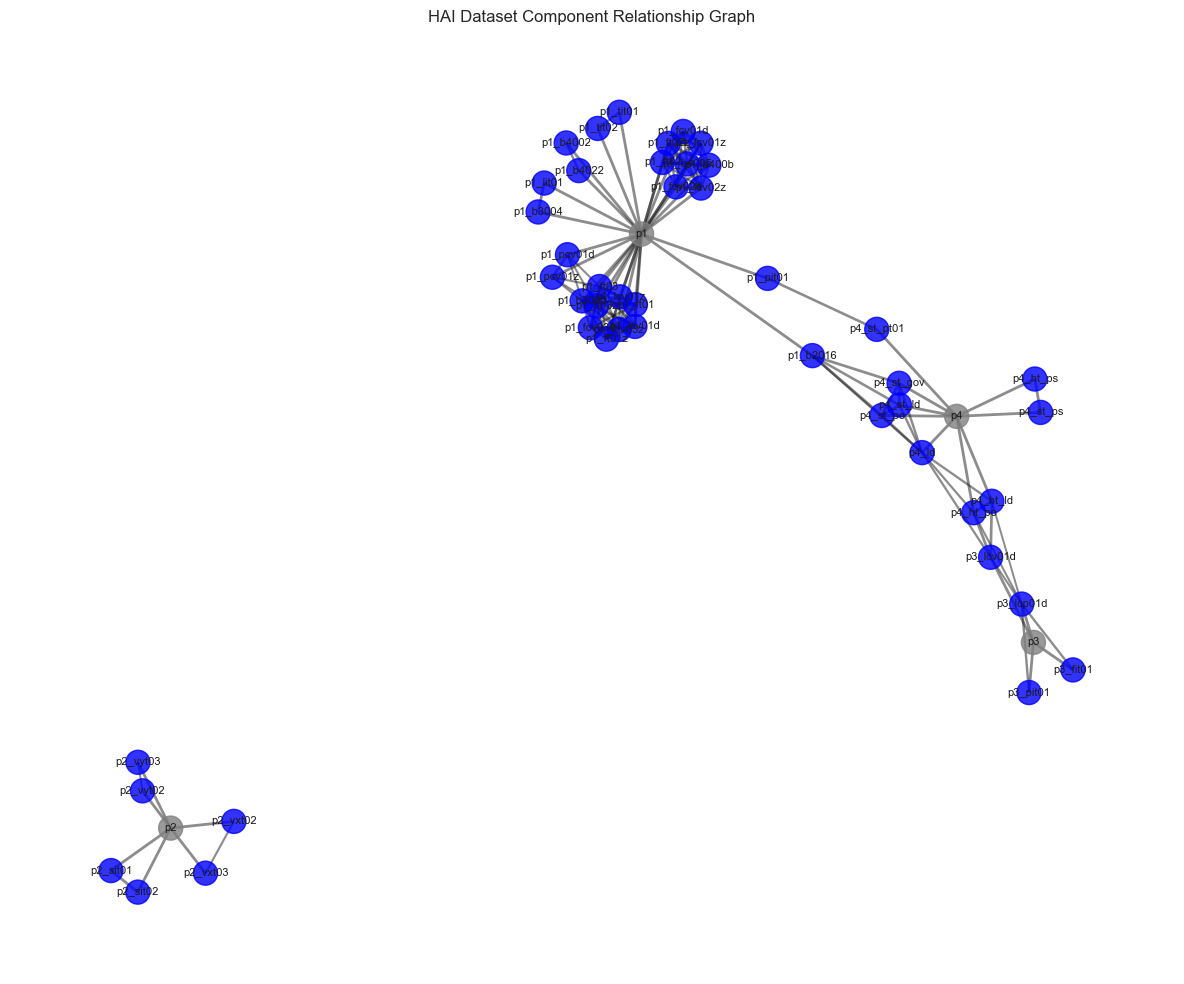

In [6]:
# Visualize graph
def visualize_graph(G, max_nodes=50):
    """
    Visualize a graph, limiting to max_nodes if the graph is too large.
    
    Args:
        G (nx.Graph): NetworkX graph
        max_nodes (int): Maximum number of nodes to display
    """
    if G.number_of_nodes() > max_nodes:
        # Get the most connected nodes
        degrees = dict(G.degree())
        top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:max_nodes]
        G_sub = G.subgraph(top_nodes)
        print(f"Showing subgraph with {G_sub.number_of_nodes()} nodes and {G_sub.number_of_edges()} edges")
        G_vis = G_sub
    else:
        G_vis = G
    
    plt.figure(figsize=(12, 10))
    
    # Set node colors based on type
    node_colors = []
    for node in G_vis.nodes():
        node_type = G_vis.nodes[node].get('type', 'unknown')
        if node_type == 'subsystem':
            node_colors.append('red')
        elif node_type == 'component':
            node_colors.append('blue')
        else:
            node_colors.append('gray')
    
    # Set edge widths based on weight
    edge_widths = [G_vis[u][v].get('weight', 1.0) * 2 for u, v in G_vis.edges()]
    
    # Draw the graph
    pos = nx.spring_layout(G_vis, seed=42)
    nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=300, alpha=0.8)
    nx.draw_networkx_edges(G_vis, pos, width=edge_widths, alpha=0.5)
    nx.draw_networkx_labels(G_vis, pos, font_size=8)
    
    plt.title("HAI Dataset Component Relationship Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize graph
visualize_graph(G)

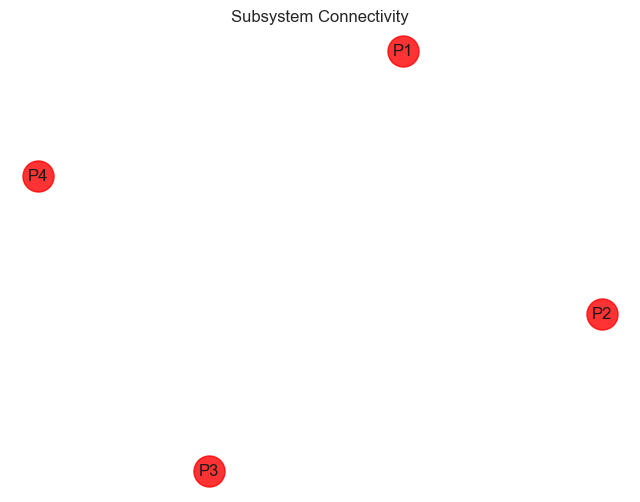

In [7]:
# Visualize subsystem connectivity
subsystems = ['P1', 'P2', 'P3', 'P4']
subsystem_graph = G.subgraph(subsystems)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(subsystem_graph, seed=42)
nx.draw_networkx_nodes(subsystem_graph, pos, node_color='red', node_size=500, alpha=0.8)
nx.draw_networkx_edges(subsystem_graph, pos, width=2, alpha=0.5)
nx.draw_networkx_labels(subsystem_graph, pos, font_size=12)
plt.title("Subsystem Connectivity")
plt.axis('off')
plt.show()

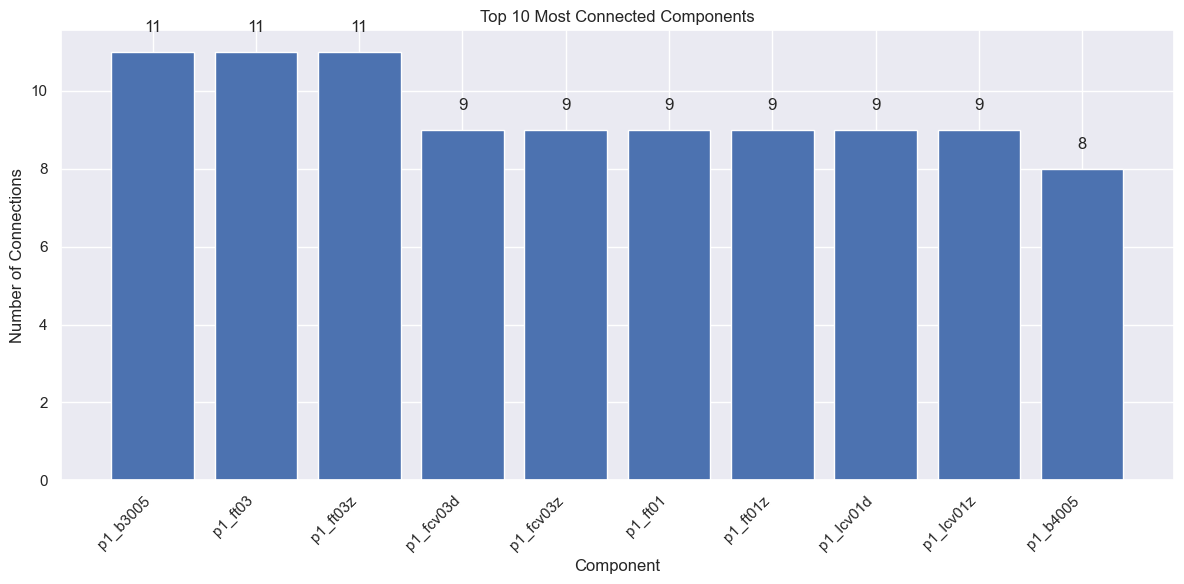

In [8]:
# Analyze node connectivity
degrees = dict(G.degree())
component_degrees = {node: degree for node, degree in degrees.items() 
                    if G.nodes[node].get('type') == 'component'}

# Get top 10 most connected components
top_components = sorted(component_degrees.items(), key=lambda x: x[1], reverse=True)[:10]

plt.figure(figsize=(12, 6))
plt.bar([comp[0] for comp in top_components], [comp[1] for comp in top_components])
plt.title('Top 10 Most Connected Components')
plt.xlabel('Component')
plt.ylabel('Number of Connections')
plt.xticks(rotation=45, ha='right')
for i, (comp, degree) in enumerate(top_components):
    plt.text(i, degree + 0.5, str(degree), ha='center')
plt.tight_layout()
plt.show()

## 4. Graph-Based Feature Engineering

In [9]:
def simplified_graph_based_feature_engineering(df, G):
    """
    Create simplified graph-based features.
    
    Args:
        df (pd.DataFrame): DataFrame with sensor/actuator data
        G (nx.Graph): NetworkX graph
        
    Returns:
        pd.DataFrame: DataFrame with additional graph-based features
    """
    df_processed = df.copy()
    
    # Extract columns excluding time and attack columns
    cols = [col for col in df.columns if not col.startswith('time') and not col.startswith('attack')]
    
    # Add subsystem-level features
    for subsystem in ['P1', 'P2', 'P3', 'P4']:
        subsystem_cols = [col for col in cols if col.startswith(f"{subsystem}_")]
        if subsystem_cols:
            # Calculate subsystem-level statistics
            df_processed[f"{subsystem}_graph_mean"] = df[subsystem_cols].mean(axis=1)
            df_processed[f"{subsystem}_graph_std"] = df[subsystem_cols].std(axis=1)
            df_processed[f"{subsystem}_graph_max"] = df[subsystem_cols].max(axis=1)
            df_processed[f"{subsystem}_graph_min"] = df[subsystem_cols].min(axis=1)
    
    # Add cross-subsystem features
    subsystems = ['P1', 'P2', 'P3', 'P4']
    for i, s1 in enumerate(subsystems):
        for j, s2 in enumerate(subsystems):
            if i < j:
                # Calculate ratio and difference between subsystem means
                if f"{s1}_graph_mean" in df_processed.columns and f"{s2}_graph_mean" in df_processed.columns:
                    s2_mean = df_processed[f"{s2}_graph_mean"].replace(0, 1e-10)  # Avoid division by zero
                    df_processed[f"{s1}_{s2}_ratio"] = df_processed[f"{s1}_graph_mean"] / s2_mean
                    df_processed[f"{s1}_{s2}_diff"] = df_processed[f"{s1}_graph_mean"] - df_processed[f"{s2}_graph_mean"]
    
    # Add rolling window features
    window_sizes = [10]  # Use a single window size for simplicity
    for window in window_sizes:
        for subsystem in subsystems:
            col = f"{subsystem}_graph_mean"
            if col in df_processed.columns:
                df_processed[f"{col}_rolling_{window}_mean"] = df_processed[col].rolling(window=window).mean()
                df_processed[f"{col}_rolling_{window}_std"] = df_processed[col].rolling(window=window).std()
    
    # Fill NaN values
    df_processed = df_processed.fillna(method='bfill').fillna(method='ffill')
    
    return df_processed

In [10]:
# Apply graph-based feature engineering to training data
train_df_processed = simplified_graph_based_feature_engineering(train_df, G)

# Print feature counts
print(f"Original train features: {train_df.shape[1]}")
print(f"Processed train features: {train_df_processed.shape[1]}")
print(f"New features added: {train_df_processed.shape[1] - train_df.shape[1]}")

Original train features: 84
Processed train features: 84
New features added: 0


In [11]:
# Visualize new features
new_features = [col for col in train_df_processed.columns if col not in train_df.columns]
print(f"New features: {new_features}")

# Plot a few new features
sample_size = 1000  # Take a sample for visualization
sample_features = new_features[:5]  # Take first 5 new features

plt.figure(figsize=(15, 10))
for i, feature in enumerate(sample_features):
    plt.subplot(len(sample_features), 1, i+1)
    plt.plot(train_df_processed[feature].iloc[:sample_size])
    plt.title(f'Time Series of {feature}')
    plt.xlabel('Time')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

New features: []


<Figure size 1500x1000 with 0 Axes>

In [12]:
# Apply graph-based feature engineering to test data
test_data_processed = {}
for name, df in test_data.items():
    test_data_processed[name] = simplified_graph_based_feature_engineering(df, G)
    print(f"Processed {name}: {df.shape[1]} original features, {test_data_processed[name].shape[1]} processed features")

Processed test1: 84 original features, 84 processed features
Processed test2: 84 original features, 84 processed features
Processed test3: 84 original features, 84 processed features
Processed test4: 84 original features, 84 processed features
Processed test5: 84 original features, 84 processed features


## 5. Feature Selection and Dimensionality Reduction

In [13]:
# Exclude non-numeric and target columns
exclude_cols = ['time', 'attack', 'attack_p1', 'attack_p2', 'attack_p3']
feature_cols = [col for col in train_df_processed.columns if col not in exclude_cols and 
                pd.api.types.is_numeric_dtype(train_df_processed[col])]

# Calculate feature importance (using variance)
variances = train_df_processed[feature_cols].var()
feature_importance = {feature: score for feature, score in zip(feature_cols, variances)}

# Select top features
N_FEATURES = 50  # Number of top features to select
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
top_features = [f[0] for f in sorted_features[:min(N_FEATURES, len(sorted_features))]]

print(f"Selected {len(top_features)} features out of {len(feature_cols)}")
print(f"Top 10 features: {top_features[:10]}")

Selected 50 features out of 79
Top 10 features: ['p3_lcv01d', 'p3_lcp01d', 'p3_lit01', 'p4_st_gov', 'p3_fit01', 'p1_b400b', 'p1_ft02z', 'p3_pit01', 'p1_ft02', 'p1_ft01z']


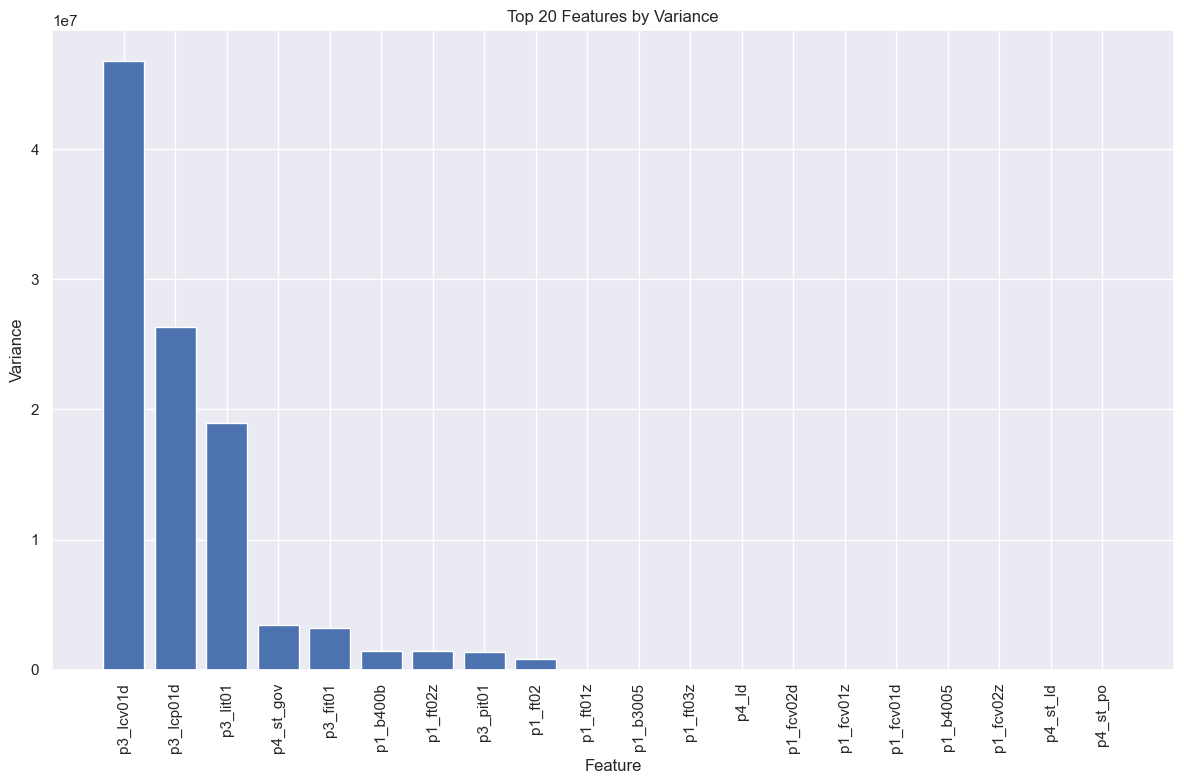

In [14]:
# Visualize feature importance
top_20_features = sorted_features[:20]
plt.figure(figsize=(12, 8))
plt.bar([f[0] for f in top_20_features], [f[1] for f in top_20_features])
plt.title('Top 20 Features by Variance')
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [15]:
# Extract features
X_train_features = train_df_processed[top_features].values

# Scale data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_features)

# Apply PCA for dimensionality reduction
N_COMPONENTS = 20  # Number of PCA components
pca = PCA(n_components=N_COMPONENTS)
X_train_pca = pca.fit_transform(X_train_scaled)

print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"PCA reduced dimensions from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]}")

Explained variance ratio: 0.9988
PCA reduced dimensions from 50 to 20


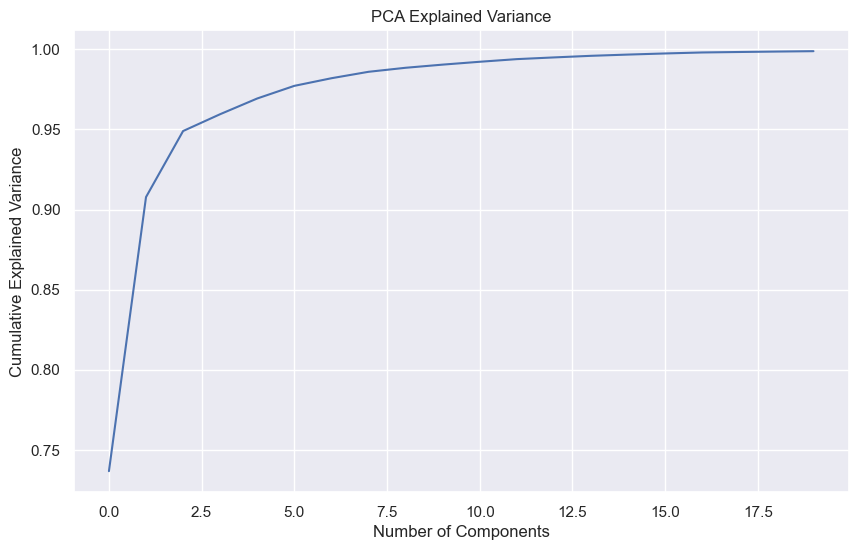

In [16]:
# Visualize PCA components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

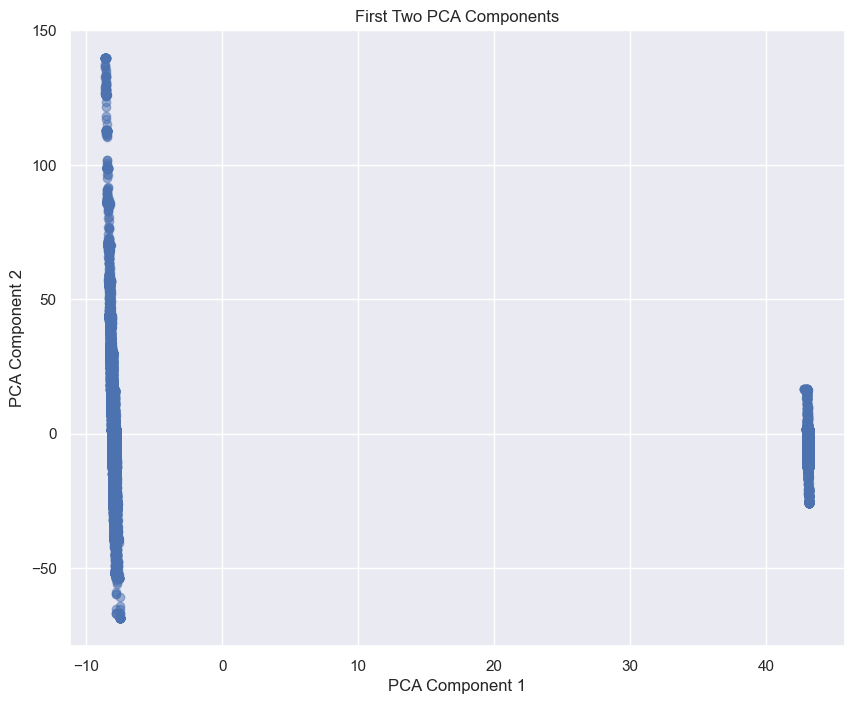

In [17]:
# Visualize first two PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5)
plt.title('First Two PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

## 6. Save Processed Data for Next Notebook

In [18]:
# Save processed training data
train_df_processed.to_csv(os.path.join(OUTPUT_DIR, 'train_processed.csv'), index=False)
print(f"Saved processed training data to {os.path.join(OUTPUT_DIR, 'train_processed.csv')}")

# Save test data
for name, df in test_data_processed.items():
    df.to_csv(os.path.join(OUTPUT_DIR, f"{name}_processed.csv"), index=False)
    print(f"Saved processed test data to {os.path.join(OUTPUT_DIR, f'{name}_processed.csv')}")

# Save feature information
feature_info = {
    'top_features': top_features,
    'n_components': N_COMPONENTS
}

import pickle
with open(os.path.join(OUTPUT_DIR, 'feature_info.pkl'), 'wb') as f:
    pickle.dump(feature_info, f)

# Save scaler and PCA
with open(os.path.join(OUTPUT_DIR, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
    
with open(os.path.join(OUTPUT_DIR, 'pca.pkl'), 'wb') as f:
    pickle.dump(pca, f)
    
print(f"Saved feature information, scaler, and PCA to {OUTPUT_DIR}")

Saved processed training data to hai-security-dataset/processed\train_processed.csv
Saved processed test data to hai-security-dataset/processed\test1_processed.csv
Saved processed test data to hai-security-dataset/processed\test2_processed.csv
Saved processed test data to hai-security-dataset/processed\test3_processed.csv
Saved processed test data to hai-security-dataset/processed\test4_processed.csv
Saved processed test data to hai-security-dataset/processed\test5_processed.csv
Saved feature information, scaler, and PCA to hai-security-dataset/processed
